In [37]:
from numpy.lib.index_tricks import index_exp
import pandas as pd
f1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/checkins.csv', skipinitialspace=True, sep='|')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [41]:
f1 = f1.drop(labels = [0],axis = 0) # удалить неинформативную строку с индексом 0

In [42]:
f1.head()

,id,user_id,venue_id,latitude,longitude,created_at
1,984301,2041916.0,5222.0,NaN,NaN,2012-04-21 17:39:01
2,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
3,984315,1764391.0,5222.0,NaN,NaN,2012-04-21 17:37:18
4,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
5,984249,2146840.0,5222.0,NaN,NaN,2012-04-21 17:42:58


In [43]:
f1.columns

Index(['id    ', 'user_id ', 'venue_id ', 'latitude      ', 'longitude     ',
       'created_at      '],
      dtype='object')

In [44]:
f1 = f1.rename(str.strip, axis='columns') # избавляем заголовки столбцов от пробельных символов

In [45]:
# удалить строки в  которых нет координат (поля 'latitude', 'longitude' )
# f1.loc[(f1.latitude.isna()) & (f1.longitude.isna())]
f1 = f1.dropna(subset=['latitude', 'longitude'])

In [46]:
f1.count()

id            396634
user_id       396634
venue_id      396634
latitude      396634
longitude     396634
created_at    396634
dtype: int64

In [47]:
# subset = 100 000 
subset_area = f1.head(100000)

In [48]:
# сбросить индекс для новой выборки
subset_area.reset_index(drop=True, inplace=True)

In [49]:
subset_area

,id,user_id,venue_id,latitude,longitude,created_at
0,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
1,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
2,984291,105054.0,5222.0,45.523452,-122.676207,2012-04-21 17:39:22
3,984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46
4,984232,93870.0,380645.0,33.448377,-112.074037,2012-04-21 17:38:18
...,...,...,...,...,...,...
99995,123888,1019078.0,1105563.0,33.575000,-117.725556,2011-12-11 05:38:19
99996,124366,771129.0,329847.0,37.629349,-122.400087,2011-12-11 04:55:34
99997,125556,804990.0,254046.0,29.762884,-95.383061,2011-12-11 06:54:20
99998,127250,526214.0,34473.0,32.802955,-96.769923,2011-12-11 10:05:38


Кластеризация

In [50]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth

In [51]:
# список списков из двух значений numpy.ndarray
X = subset_area.loc[:, ['latitude', 'longitude']].values

In [52]:
ms = MeanShift(bandwidth=0.1, bin_seeding=True, min_bin_freq=15)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

In [53]:
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)


number of estimated clusters : 524


In [54]:
cluster_centers

array([[  40.7177164 ,  -73.99183542],
       [  33.44638027, -111.90188756],
       [  33.44841049, -112.07400428],
       ...,
       [  34.5794343 , -118.1164613 ],
       [  29.7030024 ,  -98.1244531 ],
       [  27.50342762,  -82.57431938]])

In [55]:
# координаты офисов
office_adress = np.array(
[[33.751277, -118.188740],
[25.867736, -80.324116],
[51.503016, -0.075479],
[52.378894, 4.885084],
[39.366487, 117.036146],
[-33.868457, 151.205134]
])
# 33.751277, -118.188740 (Los Angeles)
# 25.867736, -80.324116 (Miami)
# 51.503016, -0.075479 (London)
# 52.378894, 4.885084 (Amsterdam)
# 39.366487, 117.036146 (Beijing)
# -33.868457, 151.205134 (Sydney)

In [56]:
office_adress.shape

(6, 2)

In [57]:
# найти ближайший офис для каждого центра кластера
def distance(xa, ya, xb, yb):
  "расстояние между 2 точками"
  return ((xb - xa) ** 2 + (yb - ya) ** 2) ** 0.5
# для каждого центра кластера минимальное расстояние до одного из офисов
distPerOf = np.zeros(len(cluster_centers)) 
# словарь расстояние до ближайшего офиса и коордитаны этого центра кластера
dict_dist = {}
for j in range(len(cluster_centers)):
  mind = -1
  for i in office_adress:
    d = distance(*i, *cluster_centers[j])
    if d < mind or mind == -1:
      mind = d
  distPerOf[j] = mind
  dict_dist[mind] = cluster_centers[j]

In [58]:
# находим 20 ближайших к офисам центров кластеров
distPerOf.sort()
distPerOf[:20]

array([0.00783476, 0.00935332, 0.02235844, 0.05005829, 0.06476319,
       0.13410903, 0.16740596, 0.18887596, 0.19577946, 0.21181054,
       0.26560622, 0.30227012, 0.30409754, 0.31488379, 0.34084565,
       0.36356462, 0.3786875 , 0.38723645, 0.39579207, 0.40424612])

In [59]:
distPerOf[0]

0.007834758163107856

In [60]:
# решение задачи - координаты ближайшего центра кластера (более 15 элементов)
dict_dist.get(distPerOf[0])

array([-33.86063043, 151.20477593])

Визуализация точек и центров кластеров

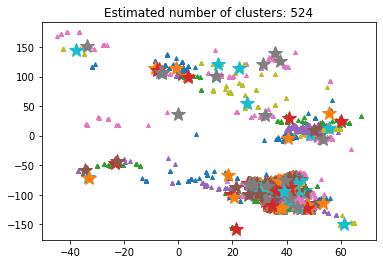

In [61]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.clf()

for k in range(n_clusters_):
    my_members = labels == k
    cluster_center = cluster_centers[k]

    # if (np.where(my_members == True, 1, 0).sum() < 15):
    #   print('kol =', np.where(my_members == True, 1, 0).sum())
    plt.plot(X[my_members, 0], X[my_members, 1], '^', markersize=4) # точки k-го кластера
    
    #центр k-го кластера
    plt.plot(       
        cluster_center[0],
        cluster_center[1],
        '*',
        markersize=14,
      )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [ ]:
np.where(my_members == True, 1, 0).sum()

100000

In [ ]:
np.where(my_members == True, 1, 0).sum()

1

______________________